# 스프린트 미션 5

### 3팀 전수현

### 제출일자: 2025.06.24


## 과제 목표: Autoencoder 기반 Denoising

1. 최종 목표: 'denoising-dirty-documents' 데이터셋의 노이즈 낀 문서 이미지를 깨끗한 원본 이미지로 복원하는 딥러닝 모델을 만든다.
2. 타겟 모델: Autoencoder
3. 중점 과제:
   - albumentations를 활용하여 Data Augmentation을 적극적으로 활용하여 모델의 일반화 성능을 높인다.
   - W&B를 연동하여 모든 실험 과정을 추적하고 시각화하여 최적의 모델 성능을 찾는다.


이번 과제에서 중점 적으로 활용할 패키지는 `albumentations`와 `W&B`이다. 전통적인 DAE 문제를 푸는 과정을 최신 패키지 적용을 통해서 구현해보는 것이 개인적인 목표이다.


## 0. Import Libraries


In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm  # 진행 상황을 보여주는 바

# PyTorch 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


# 1. 데이터 증강(Augmentation) 라이브러리
# torchvision도 좋지만, 이미지 변환에 더 강력하고 직관적인 albumentations를 사용
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 2. 실험 추적과 하이퍼 파라미터 튜닝을 위한 W&B 라이브러리 불러오기
import wandb

/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## 1. Set Configuration


In [2]:
# ====================================================================
# STEP 1: 각종 Configuration 관리
# ====================================================================
# 나중에 하이퍼파라미터 튜닝을 편하게 하려면, 이렇게 설정값을 모아두는 습관이 중요함.

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# 주요 하이퍼 파라미터
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS = 20

# data path 설정
DATA_PATH = "./data/denoising-dirty-documents/"  # 데이터셋이 있는 경로
train_dir = os.path.join(DATA_PATH, "train/train")
train_cleaned_dir = os.path.join(DATA_PATH, "train_cleaned/train_cleaned")
test_dir = os.path.join(DATA_PATH, "test/test")

Using device: cuda


In [3]:
# 해당 데이터셋의 이미지를
def load_images_from_folder(train_dir):
    images = []
    for filename in os.listdir(train_dir):
        if filename.endswith(".png"):  # PNG 파일만 가져오기
            img_path = os.path.join(train_dir, filename)
            img = cv2.imread(img_path)  # OpenCV로 이미지를 읽음 (BGR 형식)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환
            images.append(img)
    return images


train_images = load_images_from_folder(train_dir)
train_cleaned_images = load_images_from_folder(train_cleaned_dir)
test_images = load_images_from_folder(test_dir)


print(f"Train: {len(train_images)}")
print(f"Train Cleaned: {len(train_cleaned_images)}")
print(f"Test: {len(test_images)}")

Train: 144
Train Cleaned: 144
Test: 72


데이터셋의 갯수는 저렇게 구성되어 있는데 문제는 data의 크기가 일정하지 않다는 것이다.


In [4]:
# 각 데이터셋의 이미지 크기 추출
train_sizes = [
    img.shape[:2] for img in train_images
]  # train 이미지의 크기 (height, width)
train_cleaned_sizes = [
    img.shape[:2] for img in train_cleaned_images
]  # train_cleaned 이미지의 크기
test_sizes = [img.shape[:2] for img in test_images]  # test 이미지의 크기


train_unique_sizes = np.unique(train_sizes, axis=0)  # train 이미지의 유니크 크기
train_cleaned_unique_sizes = np.unique(
    train_cleaned_sizes, axis=0
)  # train_cleaned 유니크 크기
test_unique_sizes = np.unique(test_sizes, axis=0)  # test 유니크 크기
# train_unique_sizes


# 결과 출력
print("데이터 사이즈는 몇종류일까 from baseline code")
print("Unique sizes in train:\n", train_unique_sizes)
print("Unique sizes in train_cleaned:\n", train_cleaned_unique_sizes)
print("Unique sizes in test:\n", test_unique_sizes)

데이터 사이즈는 몇종류일까 from baseline code
Unique sizes in train:
 [[258 540]
 [420 540]]
Unique sizes in train_cleaned:
 [[258 540]
 [420 540]]
Unique sizes in test:
 [[258 540]
 [420 540]]


데이터 사이즈는 2가지 형태가 있기 때문에 추가적인 pre-processing 작업이 필요하다. 두 가지 경우의 수가 있는데,  
1) resize를 하거나
2) padding을 하거나  

그러나 이번 과제는 denoising 과제이므로 resizing의 경우 문서의 비율이 깨져서 글자의 특성을 망가뜨릴 수 있기 때문에 padding이 더 적합한 프로세싱일 것이다.

## 2. Load data

PyTorch의 Dataset 클래스를 상속받아서 우리 데이터셋에 맞는 클래스를 들고 데이터 로드까지.


In [5]:
# ====================================================================
# 커스텀 데이터셋 클래스 구현
# dirty_dir, clean_dir을 받아 Dataset 객체를 만들고 noise와 geometric augmentation까지
# ====================================================================
class TrainDataset(Dataset):
    def __init__(
        self,
        dirty_dir,
        clean_dir,
        transform=None,
        add_noise_to_x=False,
        var_limit=None,
    ):
        self.dirty_dir = dirty_dir
        self.clean_dir = clean_dir
        self.transform = transform
        self.dirty_images = os.listdir(self.dirty_dir)
        ## noise 정보 추가
        self.add_noise_to_x = add_noise_to_x
        self.var_limit = var_limit

    def __len__(self):
        return len(self.dirty_images)

    def __getitem__(self, index):
        img_name = self.dirty_images[index]
        dirty_img_path = os.path.join(self.dirty_dir, img_name)
        clean_img_path = os.path.join(
            self.clean_dir, img_name
        )  # clean 이미지 파일 이름이 같다고 가정

        dirty_image = np.array(Image.open(dirty_img_path).convert("RGB"))
        clean_image = np.array(Image.open(clean_img_path).convert("RGB"))

        # Augmentation 적용
        # 1. 노이즈 정보가 있다면
        if self.add_noise_to_x:
            dirty_image = self.add_custom_noise(dirty_image)
        # 2. geometric augmentation
        if self.transform:
            augmented = self.transform(image=dirty_image, clean=clean_image)
            dirty_image = augmented["image"]
            clean_image = augmented["clean"]

        return dirty_image, clean_image

    def add_custom_noise(self, image):
        noise_transform = A.Compose([A.GaussNoise(var_limit=self.var_limit, p=1.0)])

        return noise_transform(image=image)["image"]

위에서 정의한 클래스가 잘 만들어지는지 plot해보았다.

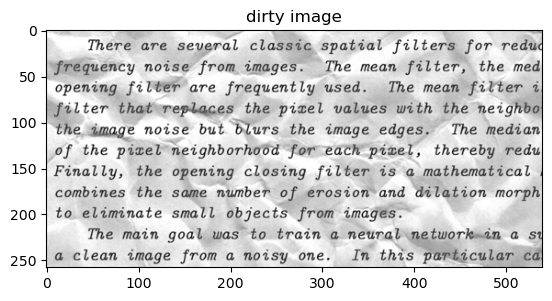

train: (258, 540, 3)


In [6]:
import matplotlib.pyplot as plt

train_data = TrainDataset(train_dir, train_cleaned_dir)
(a, b) = train_data[0]
plt.imshow(a)
plt.title("dirty image")
plt.show()
print(f"train: {a.shape}")
# a = x.shape
# a[:2]
# cv2.imshow(x)
# np.unique(train_data, axis=0)

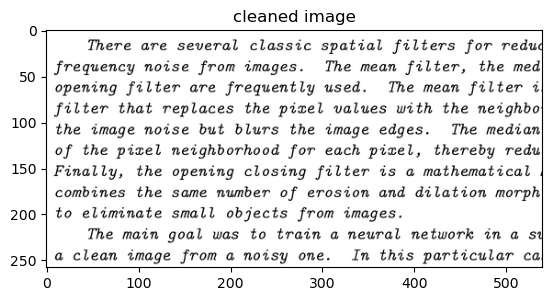

label: (258, 540, 3)


In [7]:
plt.imshow(b)
plt.title("cleaned image")
plt.show()
b.shape
print(f"label: {b.shape}")

이번 과제의 중심 주제인 Data Augmenation 파트.

In [8]:
# ====================================================================
# 데이터 증강 (Data Augmentation)
# ====================================================================
TARGET_HEIGHT = 420
TARGET_WIDTH = 540
train_transform = A.Compose(
    [
        A.ToGray(p=1.0),  # RGB → Gray
        A.LongestMaxSize(max_size=TARGET_WIDTH, interpolation=cv2.INTER_AREA),
        A.PadIfNeeded(
            min_height=TARGET_HEIGHT,
            min_width=TARGET_WIDTH,
            border_mode=cv2.BORDER_CONSTANT,
        ),  # zero-padding
        # A.Resize(),
        A.Rotate(limit=10, p=0.5),
        A.HorizontalFlip(p=0.5),
        # 정규화 및 텐서 변환
        A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
        ToTensorV2(),  # numpy 배열 (H, W, C)를 PyTorch 텐서 (C, H, W)로 변환
    ],
    additional_targets={"clean": "image"},  # clean
)

/tmp/ipykernel_199655/25455153.py:48: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  noise_transform = A.Compose([A.GaussNoise(var_limit=self.var_limit, p=1.0)])


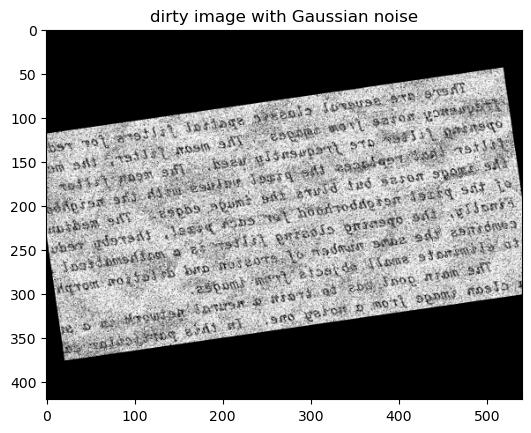

In [9]:
train_dataset = TrainDataset(
    train_dir,
    train_cleaned_dir,
    transform=train_transform,
    add_noise_to_x=True,
    var_limit=(10.0, 50.0),
)

(a, b) = train_dataset[0]
plt.imshow(a.permute(1, 2, 0))
plt.title("dirty image with Gaussian noise")
plt.show()

기존 dirty image에 Gaussian noise를 입힌 것을 볼 수 있다. 

이제 Dataloader에 이 클래스를 넘기면

In [10]:
# ====================================================================
# train 데이터로더 생성
# ====================================================================
# DenoiseDataset과 DataLoader를 사용해서 train_loader, val_loader 만들기
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
a, b = next(iter(train_loader))
# plt.imshow(a.numpy())
print(f"train: {a.shape}")
print(f"label: {b.shape}")

/tmp/ipykernel_199655/25455153.py:48: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  noise_transform = A.Compose([A.GaussNoise(var_limit=self.var_limit, p=1.0)])


train: torch.Size([8, 3, 420, 540])
label: torch.Size([8, 3, 420, 540])


/tmp/ipykernel_199655/25455153.py:48: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  noise_transform = A.Compose([A.GaussNoise(var_limit=self.var_limit, p=1.0)])


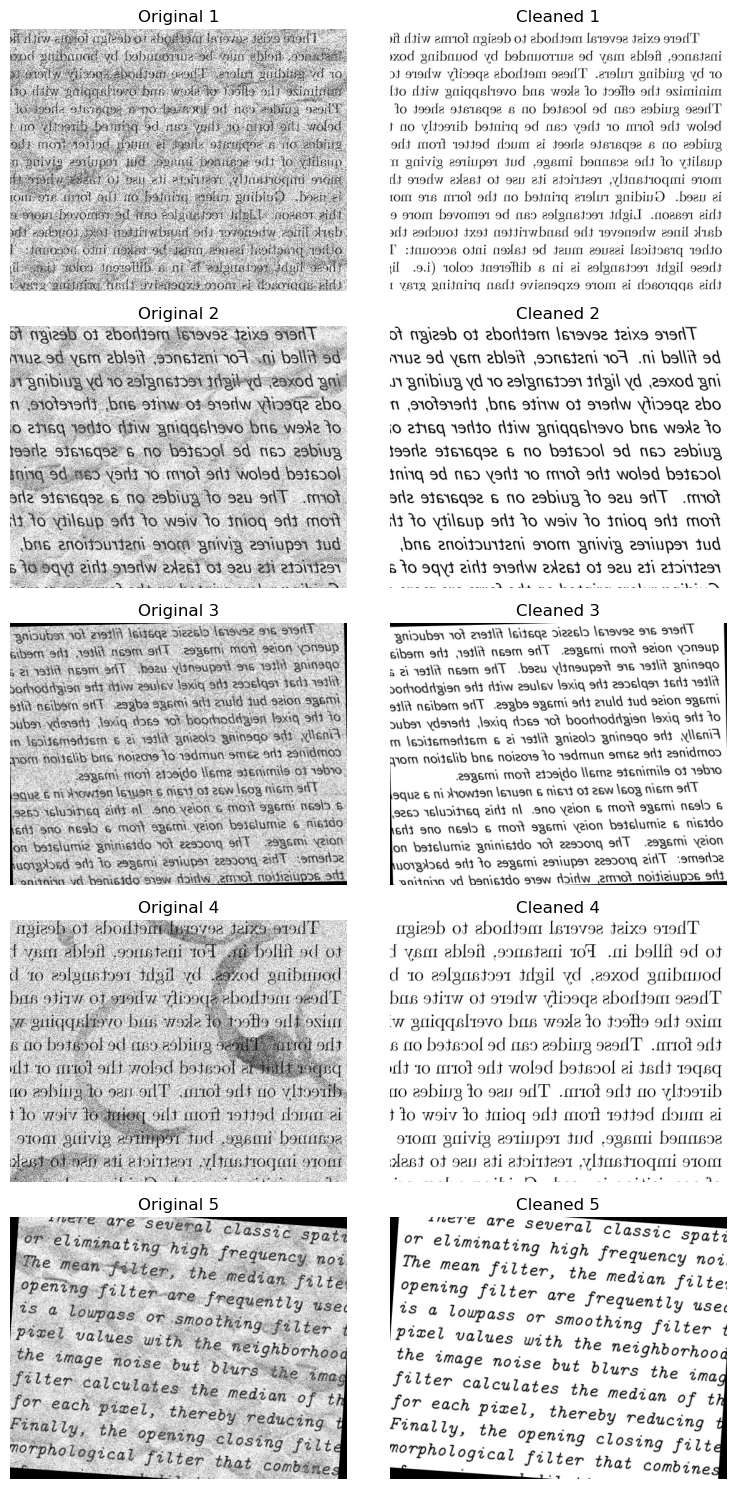

In [11]:
# 시각화 함수
def visualize_paired_dataset(paired_loader, num_images=5):
    # paired_loader에서 데이터 하나 가져오기
    for train_images, cleaned_images in paired_loader:
        # 시각화
        # print(f"train: {train_images[0].shape}")
        # print(f"label: {cleaned_images[0].shape}")

        fig, axes = plt.subplots(
            num_images, 2, figsize=(8, num_images * 3)
        )  # num_images 행, 2열 (위: train, 아래: cleaned)
        for i in range(num_images):
            # 첫 번째 열: 원본 이미지 (train)
            # print(f"train: {train_images[0].shape}")
            axes[i, 0].imshow(train_images[i].permute(1, 2, 0).numpy(), cmap="gray")
            axes[i, 0].set_title(f"Original {i+1}")
            axes[i, 0].axis("off")  # 축 비활성화

            # 두 번째 열: 정제된 이미지 (cleaned)
            # print(f"label: {cleaned_images[0].shape}")
            axes[i, 1].imshow(cleaned_images[i].permute(1, 2, 0).numpy(), cmap="gray")
            axes[i, 1].set_title(f"Cleaned {i+1}")
            axes[i, 1].axis("off")  # 축 비활성화

        plt.tight_layout()
        plt.show()
        break  # 한 번만 실행하도록 break


# PairedImageDataset에서 이미지 위아래 시각화
visualize_paired_dataset(train_loader, num_images=5)

또한 Valiadation set에 대해서

In [12]:
# ====================================================================
# val 데이터로더 생성
# ====================================================================
# train과 다르게 val에서는 패딩과 noramlization만 적용됨

val_transform = A.Compose(
    [  # zero-padding
        A.ToGray(p=1.0),  # RGB → Gray
        A.LongestMaxSize(max_size=TARGET_WIDTH, interpolation=cv2.INTER_AREA),
        A.PadIfNeeded(
            min_height=TARGET_HEIGHT,
            min_width=TARGET_WIDTH,
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
        ToTensorV2(),
    ]
)


class valDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = sorted(
            [
                os.path.join(data_dir, f)
                for f in os.listdir(data_dir)
                if f.endswith(".png")
            ]
        )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = np.array(Image.open(img_path).convert("RGB"))  # RGB로 열기

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image


val_dataset = valDataset(test_dir, transform=val_transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

next(iter(val_loader))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

## 3. Model implementation


In [ ]:
# ====================================================================
# STEP 4: U-Net 모델
# ====================================================================
# U-Net을 구성하는 기본 블록 (Convolution 2번)

import torchvision.transforms.functional as TF


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(
                out_channels
            ),  # BatchNorm은 학습을 안정시켜주는 아주 중요한 역할!
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


# U-Net 모델 본체
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 1. Encoder (Downsampling path)
        # 이미지 크기를 줄여가며 특징을 추출하는 부분
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # 2. Decoder (Upsampling path)
        # 다시 이미지 크기를 키워가며 복원하는 부분
        for feature in reversed(features):
            # Up-Convolution 정의 (크기를 2배 키움)
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            # 일반적인 DoubleConv 정의
            self.ups.append(DoubleConv(feature * 2, feature))

        # 3. U-Net의 가장 아랫단 (병목 구간)
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # 4. 최종 출력 레이어
        # 채널 수를 out_channels(우리 경우는 3)로 맞춰주는 1x1 Conv
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder 실행
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)  # Skip Connection을 위해 중간 결과물 저장
            x = self.pool(x)

        # Bottleneck 실행
        x = self.bottleneck(x)

        # skip_connections 순서를 뒤집어줌 (가장 나중에 저장된 것부터 쓰기 위해)
        skip_connections = skip_connections[::-1]

        # --- Decoder 실행 ---
        # ups 리스트에는 [UpConv, DoubleConv, UpConv, DoubleConv, ...] 순서로 들어있음
        for i in range(0, len(self.ups), 2):
            # 먼저 Up-Convolution으로 크기를 키움
            x = self.ups[i](x)

            # Skip Connection 할 피처맵을 가져옴
            skip_connection = skip_connections[i // 2]

            # 만약 upsampling된 x와 skip_connection의 크기가 다르면, x의 크기에 맞게 강제로 리사이즈
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # 채널 방향(dim=1)으로 두 피처맵을 합쳐줌 (Concat)
            concat_skip = torch.cat((skip_connection, x), dim=1)

            # 합쳐진 피처맵을 DoubleConv에 통과시킴
            x = self.ups[i + 1](concat_skip)

        # 최종 출력
        return self.final_conv(x)

## 4. Train a model


In [14]:
# ====================================================================
# STEP 5-1: 학습 및 검증 함수 구현
# ====================================================================


def train_fn(loader, model, optimizer, loss_fn, scaler=None):
    model.train()  # 모델을 훈련 모드로 설정
    loop = tqdm(loader, desc="Training")  # 진행 바에 이름 추가

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE, dtype=torch.float32)
        targets = targets.to(device=DEVICE, dtype=torch.float32)

        # Forward
        predictions = model(data)
        loss = loss_fn(predictions, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # W&B에 훈련 loss 기록 (매 스텝마다)
        # step 인자를 주면 x축이 batch step 기준으로 그려져서 더 상세히 볼 수 있어.
        wandb.log({"train_loss": loss.item()})

        # tqdm 진행 바에 현재 loss 업데이트
        loop.set_postfix(loss=loss.item())


def validate_fn(loader, model, loss_fn, device):
    """validation 데이터에 대한 성능을 평가하고, 결과 이미지를 시각화하는 함수"""
    model.eval()  # 모델을 평가 모드로 설정
    loop = tqdm(
        loader, desc="Validating", leave=False
    )  # 학습 루프 안에 있으니 leave=False로 깔끔하게
    val_loss = 0

    # 평가 시에는 gradient 계산이 필요 없으므로 torch.no_grad() 사용
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(loop):
            data = data.to(device=device, dtype=torch.float32)
            targets = targets.to(device=device, dtype=torch.float32)

            predictions = model(data)
            loss = loss_fn(predictions, targets)
            val_loss += loss.item()

            # 첫 번째 배치에 대해서만 결과 이미지 기록 (매 에포크마다)
            if batch_idx == 0:
                # 텐서를 시각화 가능한 형태로 변환 (배치 중 첫번째 이미지)
                # (C, H, W) -> (H, W, C) & CPU로 이동 & NumPy로 변환
                original_img = data[0].permute(1, 2, 0).cpu().numpy()
                denoised_img = predictions[0].permute(1, 2, 0).cpu().numpy()
                clean_img = targets[0].permute(1, 2, 0).cpu().numpy()

                # 3개 이미지를 가로로 이어붙여서 비교하기 쉽게 만듦
                comparison_img = np.concatenate(
                    [original_img, denoised_img, clean_img], axis=1
                )

                # W&B에 이미지 기록
                wandb.log(
                    {
                        "validation_images": wandb.Image(
                            comparison_img, caption="Input | Prediction | Ground Truth"
                        )
                    }
                )

    # 전체 validation loss의 평균 계산
    avg_val_loss = val_loss / len(loader)

    # W&B에 평균 validation loss 기록 (에포크마다)
    wandb.log({"validation_loss": avg_val_loss})

    model.train()  # 함수가 끝나면 다시 훈련 모드로 돌려놓기
    return avg_val_loss

In [15]:
model = UNET(in_channels=3, out_channels=3).to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
best_val_loss = float("inf")  # 가장 좋은 validation loss를 기록하기 위한 변수

In [16]:
wandb.init(
    project="denoising-autoencoder",
    config={
        "learning_rate": LEARNING_RATE,
        "epochs": NUM_EPOCHS,
        "batch_size": BATCH_SIZE,  # BATCH_SIZE 변수 사용
        "model_architecture": "U-Net",
        "dataset": "denoising-dirty-documents",
    },
)
# W&B가 모델의 그래디언트와 파라미터를 추적하게 함
wandb.watch(model, log="all")


# 4. 학습 시작!
print("Training started!")
for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")

    # 훈련 함수 실행
    train_fn(train_loader, model, optimizer, loss_fn)

    # 검증 함수 실행
    # current_val_loss = validate_fn(val_loader, model, loss_fn, device=DEVICE)
    # print(f"Validation Loss: {current_val_loss:.4f}")

    # validation 성능이 가장 좋을 때 모델 저장하기
    # if current_val_loss < best_val_loss:
    #     print(
    #         f"Validation loss improved ({best_val_loss:.4f} --> {current_val_loss:.4f}). Saving model..."
    #     )
    #     best_val_loss = current_val_loss
    torch.save(model.state_dict(), f"best_model_{epoch}.pth")

# 학습 완료 후 W&B 종료
wandb.finish()
print("🎉 Training finished!")

wandb: Currently logged in as: jssseh (jssseh-yonsei-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training started!

--- Epoch 1/20 ---


Training:   0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_199655/25455153.py:48: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  noise_transform = A.Compose([A.GaussNoise(var_limit=self.var_limit, p=1.0)])
Training: 100%|██████████| 18/18 [42:07<00:00, 140.44s/it, loss=0.407]



--- Epoch 2/20 ---


Training: 100%|██████████| 18/18 [42:12<00:00, 140.69s/it, loss=0.438]



--- Epoch 3/20 ---


Training: 100%|██████████| 18/18 [42:33<00:00, 141.85s/it, loss=0.203]



--- Epoch 4/20 ---


Training: 100%|██████████| 18/18 [42:12<00:00, 140.67s/it, loss=0.131] 



--- Epoch 5/20 ---


Training: 100%|██████████| 18/18 [42:29<00:00, 141.66s/it, loss=0.133] 



--- Epoch 6/20 ---


Training: 100%|██████████| 18/18 [41:53<00:00, 139.62s/it, loss=0.0447]



--- Epoch 7/20 ---


Training: 100%|██████████| 18/18 [42:11<00:00, 140.66s/it, loss=0.0316]



--- Epoch 8/20 ---


Training: 100%|██████████| 18/18 [42:44<00:00, 142.50s/it, loss=0.0659]



--- Epoch 9/20 ---


Training: 100%|██████████| 18/18 [43:48<00:00, 146.01s/it, loss=0.0423]



--- Epoch 10/20 ---


Training: 100%|██████████| 18/18 [42:37<00:00, 142.08s/it, loss=0.0343]



--- Epoch 11/20 ---


Training: 100%|██████████| 18/18 [42:35<00:00, 141.98s/it, loss=0.0232]



--- Epoch 12/20 ---


Training: 100%|██████████| 18/18 [42:48<00:00, 142.72s/it, loss=0.0388]



--- Epoch 13/20 ---


Training: 100%|██████████| 18/18 [42:24<00:00, 141.36s/it, loss=0.0146]



--- Epoch 14/20 ---


Training: 100%|██████████| 18/18 [42:01<00:00, 140.06s/it, loss=0.0105]



--- Epoch 15/20 ---


Training: 100%|██████████| 18/18 [43:00<00:00, 143.38s/it, loss=0.00825]



--- Epoch 16/20 ---


Training: 100%|██████████| 18/18 [43:15<00:00, 144.19s/it, loss=0.0101] 



--- Epoch 17/20 ---


Training: 100%|██████████| 18/18 [42:09<00:00, 140.52s/it, loss=0.0159] 



--- Epoch 18/20 ---


Training: 100%|██████████| 18/18 [42:07<00:00, 140.40s/it, loss=0.0193] 



--- Epoch 19/20 ---


Training: 100%|██████████| 18/18 [41:48<00:00, 139.34s/it, loss=0.0176] 



--- Epoch 20/20 ---


Training: 100%|██████████| 18/18 [41:41<00:00, 138.97s/it, loss=0.00868]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


train_loss,██▇▆▇▄▂▃▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.00868


🎉 Training finished!


In [17]:
# ====================================================================
# STEP 6: 평가 및 시각화
# ====================================================================
# TODO: 저장된 best_model.pth 불러오기
# model.load_state_dict(...)

# TODO: TEST 데이터셋에서 몇 개의 이미지를 가져와서
# [노이즈 이미지] vs [모델이 복원한 이미지]

# 테스트
model.eval()
with torch.no_grad():
    for images in val_loader:
        # print(images.size())
        images = torch.tensor(images)
        images = images.to(DEVICE)  # 원본 이미지
        outputs = model(images)  # 출력
        # print(outputs.size())
        break

/tmp/ipykernel_199655/2490199709.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images)


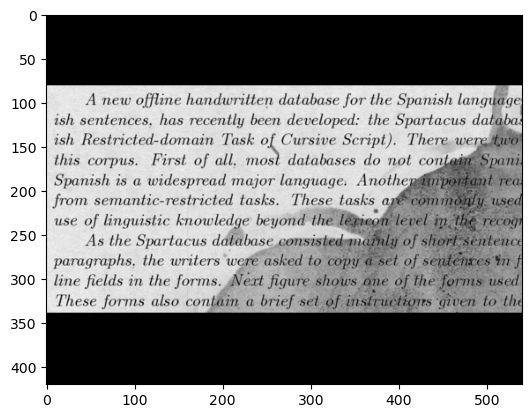

In [18]:
plt.imshow(images[0].cpu().permute(1, 2, 0).numpy().squeeze())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07803407..2.288199].


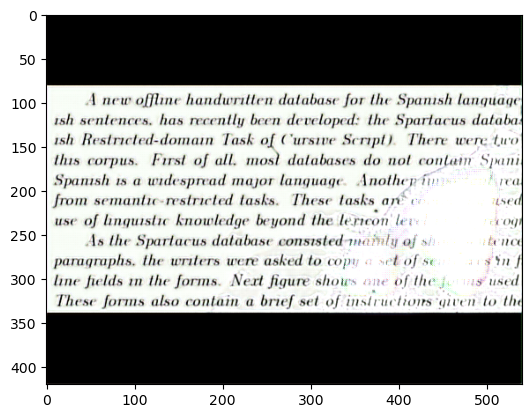

In [21]:
plt.imshow(outputs.cpu().squeeze().permute(1, 2, 0))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

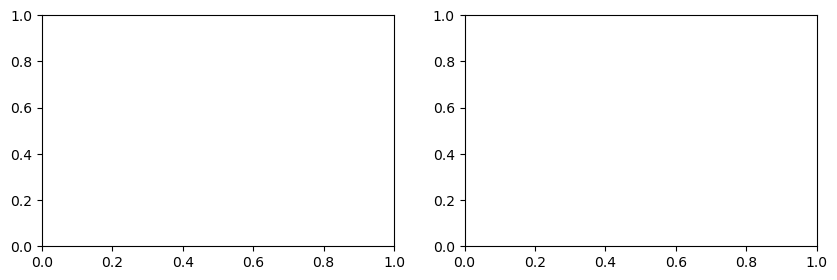

In [20]:
def visualize_images_and_outputs(images, outputs):
    """
    이미지와 출력 이미지를 열로 구분하여 시각화.
    :param images: 원본 이미지 텐서
    :param outputs: 모델 출력 텐서
    """
    num_images = images.size(0)  # 전체 이미지 개수
    fig, axes = plt.subplots(
        num_images, 2, figsize=(10, num_images * 3)
    )  # num_images 행, 2열

    for i in range(num_images):
        # 첫 번째 열: 원본 이미지
        axes[i, 0].imshow(
            images[i].cpu().permute(1, 2, 0).numpy().squeeze(), cmap="gray"
        )
        axes[i, 0].set_title(f"input {i + 1}", fontsize=10)
        axes[i, 0].axis("off")

        # 두 번째 열: 출력 이미지
        axes[i, 1].imshow(
            outputs[i].cpu().permute(1, 2, 0).detach().numpy().squeeze(), cmap="gray"
        )
        axes[i, 1].set_title(f"Result {i + 1}", fontsize=10)
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


visualize_images_and_outputs(images, outputs)

## 결론 및 고찰
이번 과제는 첫 딥러닝 과제로서 비록 만족할만한 결과는 아니었지만 개인적인 몇가지 목표를 달성하였다.

1) 딥러닝 수행에 대한 기본 템플릿을 디자인해보았다. 이는 앞으로 진행될 딥러닝 과제에 그대로 활용이 가능할 것이다.
2) 개인 서버 세팅부터 기본적인 파이토치 모듈을 적용하였고 W&B와 같은 모니터링 시스템도 경험할 수 있었다. 컴퓨팅 파워가 부족한 상황에서 학습을 어떻게 효율적으로 해야하나 고민을 했던 것 같다.
3) From Scrach 전략으로 코드를 0에서부터 시작하여 어느 정도 구조화에 성공하였다. 대부분의 시간은 디버깅으로 사용했으며 코드를 점진적으로 발전시켜 나갔다.
4) 대표적인 Unet을 활용하여 denoising 과제를 수행해보았고 data-driven 방식의 접근을 시도하였다.